# FASE 1 – Comprensión del Negocio

Empresa Ficticia: ShopNow

ShopNow es una plataforma de e-commerce que opera en Guatemala, México, Colombia, Chile y Perú. Tiene más de 500,000 usuarios y maneja alrededor de 40,000 pedidos mensuales.

## Problema de Negocio (churn)

La empresa ha experimentado una alta tasa de abandono de clientes durante los últimos 12 meses. Esto afecta directamente el ingreso porque los clientes que abandonan dejan de comprar, usar cupones y consumir productos premium.

## Impacto económico estimado

- Valor promedio de un cliente activo: Q 420 anuales

- Abandono promedio mensual: 8%

- Clientes activos: 500,000

Pérdida anual estimada:
500,000 × 0.08 × Q420 × 12 ≈ Q201,600,000

## Objetivo del proyecto

Construir un modelo de Machine Learning que prediga si un cliente abandonará la plataforma en los siguientes 30 días.

## Stakeholders involucrados

| Stakeholder         | Necesidad                                             |
| ------------------- | ----------------------------------------------------- |
| Equipo de Marketing | Campañas de retención, segmentación inteligente       |
| Data Team           | Pipeline reproducible y automatizado                  |
| Gerencia            | Reducción del churn en un 15% trimestral              |
| Equipo de Producto  | Mejorar la experiencia del usuario basado en insights |

## Restricciones

- Tiempo máximo de desarrollo: 3 semanas

- Recursos computacionales limitados

- Modelo debe poder exponerse vía API

- El proyecto debe registrarse con MLflow

# FASE 2 – Comprensión de los Datos (EDA)

In [11]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

np.random.seed(42)

N = 10000

# ----------------------------
# 1. Datos básicos del cliente
# ----------------------------
customer_id = np.arange(1, N + 1)

age = np.random.randint(18, 70, N)
gender = np.random.choice(["M", "F"], N)
country = np.random.choice(
    ["Guatemala", "México", "Colombia", "Chile", "Perú"],
    N, p=[0.25, 0.25, 0.20, 0.15, 0.15]
)

# Fechas de registro entre 2019–2024
signup_date = pd.to_datetime(
    np.random.randint(
        datetime(2019, 1, 1).timestamp(),
        datetime(2024, 1, 1).timestamp(),
        N
    ),
    unit="s"
)

# --------------------------------
# 2. Comportamiento del usuario
# --------------------------------
last_login_days = np.random.exponential(scale=30, size=N).astype(int)

total_orders = np.random.poisson(lam=5, size=N)
avg_order_value = np.round(np.random.normal(50, 25, N).clip(5, 500), 2)

support_tickets = np.random.poisson(lam=0.3, size=N)
payment_issues = np.random.binomial(1, 0.1, size=N)
loyalty_points = np.random.randint(0, 5000, N)

# --------------------------------
# 3. Marketing & Engagement
# --------------------------------
email_open_rate = np.round(np.random.beta(2, 5, N), 3)
sms_click_rate = np.round(np.random.beta(1.5, 6, N), 3)
promotion_usage = np.round(np.random.beta(2, 3, N), 3)

# --------------------------------
# 4. Última compra (fecha realista)
# --------------------------------
last_purchase_date = signup_date + pd.to_timedelta(
    np.random.randint(0, 1800, N), unit="D"
)

days_since_last_purchase = (datetime.now() - last_purchase_date).days
days_since_last_purchase = np.clip(days_since_last_purchase, a_min=0, a_max=None)

# --------------------------------
# 5. Variable objetivo (churn)
#    Con reglas realistas
# --------------------------------
# Score con peso realista
score = (
    (days_since_last_purchase > 120) * 0.35 +
    (last_login_days > 60) * 0.30 +
    (total_orders == 0) * 0.20 +
    (payment_issues == 1) * 0.10 +
    (email_open_rate < 0.1) * 0.05
)

prob = np.clip(score, 0, 1)
churn = np.random.binomial(1, prob)

# Balanceamos a ~50%
churn = np.where(np.random.rand(N) < 0.5, churn, 0)

# ----------------------------
# Construir DataFrame final
# ----------------------------
df = pd.DataFrame({
    "customer_id": customer_id,
    "age": age,
    "gender": gender,
    "country": country,
    "signup_date": signup_date,
    "last_login_days": last_login_days,
    "total_orders": total_orders,
    "avg_order_value": avg_order_value,
    "support_tickets": support_tickets,
    "payment_issues": payment_issues,
    "loyalty_points": loyalty_points,
    "email_open_rate": email_open_rate,
    "sms_click_rate": sms_click_rate,
    "promotion_usage": promotion_usage,
    "last_purchase_date": last_purchase_date,
    "days_since_last_purchase": days_since_last_purchase,
    "churn": churn
})

df.head()

,customer_id,age,gender,country,signup_date,last_login_days,total_orders,avg_order_value,support_tickets,payment_issues,loyalty_points,email_open_rate,sms_click_rate,promotion_usage,last_purchase_date,days_since_last_purchase,churn
0,1,56,M,Guatemala,2019-05-21 05:51:02,4,5,5.00,0,0,3630,0.229,0.034,0.287,2020-02-16 05:51:02,2098,0
1,2,69,F,México,2020-11-27 17:47:52,31,9,41.94,0,0,736,0.147,0.114,0.546,2024-11-10 17:47:52,369,1
2,3,46,F,Chile,2020-01-11 06:44:03,26,5,51.84,0,1,1475,0.226,0.447,0.069,2023-05-05 06:44:03,924,1
3,4,32,F,México,2019-03-02 07:39:22,0,1,64.28,0,0,4175,0.085,0.101,0.470,2019-07-21 07:39:22,2308,1
4,5,60,M,México,2023-10-14 07:59:02,10,4,10.37,2,0,303,0.388,0.319,0.453,2025-08-20 07:59:02,86,0


## 2.1 Estructura del dataset

In [12]:
df.info()
df.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_id               10000 non-null  int64         
 1   age                       10000 non-null  int64         
 2   gender                    10000 non-null  object        
 3   country                   10000 non-null  object        
 4   signup_date               10000 non-null  datetime64[ns]
 5   last_login_days           10000 non-null  int64         
 6   total_orders              10000 non-null  int64         
 7   avg_order_value           10000 non-null  float64       
 8   support_tickets           10000 non-null  int64         
 9   payment_issues            10000 non-null  int64         
 10  loyalty_points            10000 non-null  int64         
 11  email_open_rate           10000 non-null  float64       
 12  sms_click_rate     

,customer_id,age,gender,country,signup_date,last_login_days,total_orders,avg_order_value,support_tickets,payment_issues,loyalty_points,email_open_rate,sms_click_rate,promotion_usage,last_purchase_date,days_since_last_purchase,churn
count,10000.00000,10000.000000,10000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000,10000.000000,10000.000000
unique,NaN,NaN,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,F,México,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,5022,2490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,43.539400,NaN,NaN,2021-07-06 02:59:16.616100096,29.292500,5.021400,50.593911,0.300000,0.098900,2509.647400,0.283381,0.200238,0.400212,2023-12-22 23:13:11.816100096,763.447000,0.164700
min,1.00000,18.000000,NaN,NaN,2019-01-01 00:10:17,0.000000,0.000000,5.000000,0.000000,0.000000,1.000000,0.002000,0.000000,0.000000,2019-02-12 20:42:47,0.000000,0.000000
25%,2500.75000,31.000000,NaN,NaN,2020-04-10 07:22:26,8.000000,3.000000,33.520000,0.000000,0.000000,1267.000000,0.160000,0.094000,0.243000,2022-07-15 22:14:39,176.000000,0.000000
50%,5000.50000,43.000000,NaN,NaN,2021-07-04 16:12:07,20.000000,5.000000,49.920000,0.000000,0.000000,2506.000000,0.262000,0.172500,0.386000,2023-12-23 18:48:48,692.000000,0.000000
75%,7500.25000,56.000000,NaN,NaN,2022-10-04 11:46:38.249999872,40.000000,6.000000,67.150000,1.000000,0.000000,3755.000000,0.387000,0.280000,0.544000,2025-05-22 11:36:02.750000128,1218.000000,0.000000
max,10000.00000,69.000000,NaN,NaN,2023-12-31 23:19:43,276.000000,14.000000,147.500000,4.000000,1.000000,4997.000000,0.891000,0.860000,0.973000,2028-11-29 12:44:46,2467.000000,1.000000


## 2.2 Distribución del Target

In [48]:
from sklearn.utils import resample

df_majority = df[df.churn == 0]
df_minority = df[df.churn == 1]

df_minority_up = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_balanced = pd.concat([df_majority, df_minority_up])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [49]:
df_balanced["churn"].value_counts(normalize=True)


,proportion
churn,
0,0.5
1,0.5


In [38]:
import os

output_dir = "data"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

df.to_csv(os.path.join(output_dir, "dataset_churn_sintetico.csv"), index=False)
print(f"Dataset guardado en {output_dir}/")

Dataset guardado en data/


## 2.3 Gráficos
### Distribución de edad

<Axes: xlabel='age', ylabel='Count'>

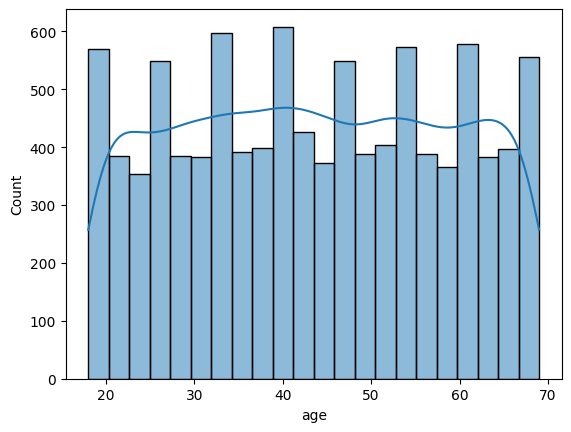

In [39]:
import seaborn as sns
sns.histplot(df["age"], kde=True)


### Churn por país

<Axes: xlabel='country', ylabel='churn'>

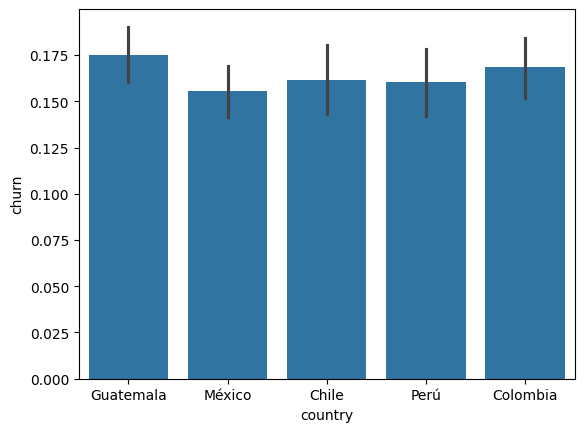

In [40]:
sns.barplot(x="country", y="churn", data=df)


### Correlación

<Axes: >

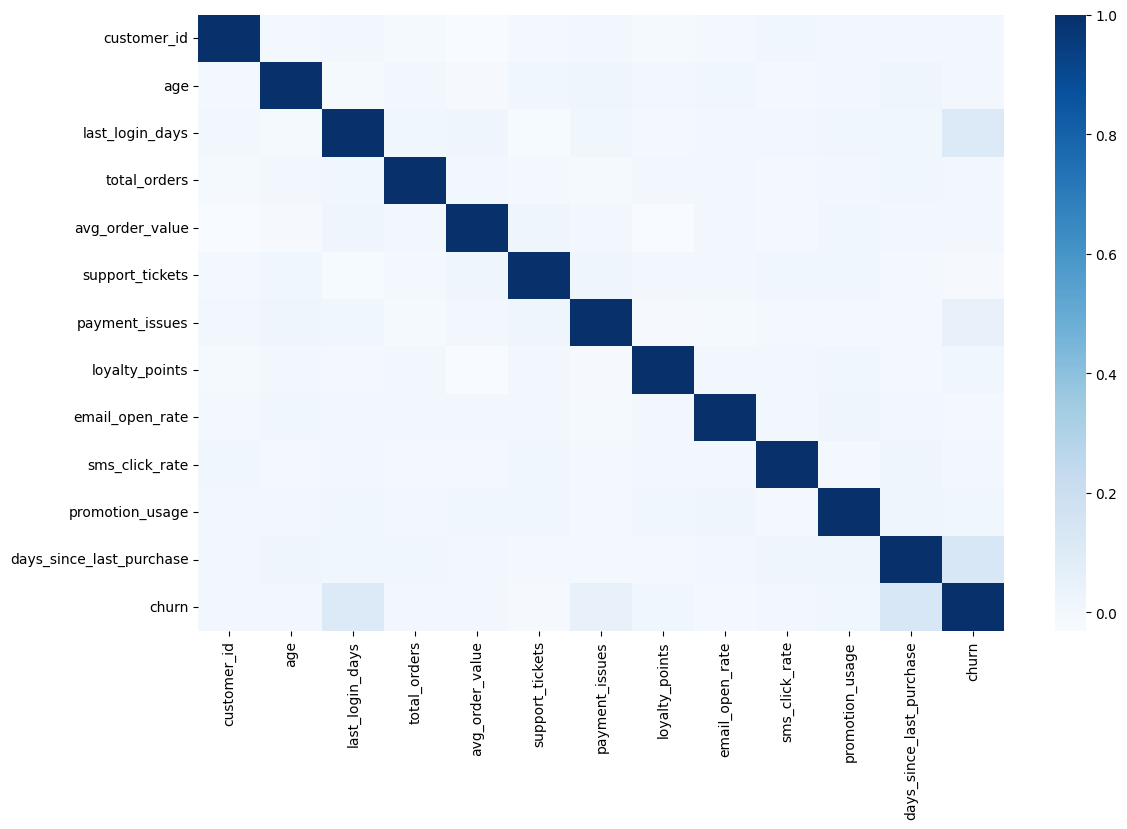

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(13,8))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="Blues")


## FASE 3 – Preparación de los Datos

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def data_pipeline(df):

    df = df.copy()

    # Eliminar duplicados
    df.drop_duplicates(inplace=True)

    # Manejo de valores faltantes
    df.fillna({
        "email_open_rate": df["email_open_rate"].median(),
        "sms_click_rate": df["sms_click_rate"].median()
    }, inplace=True)

    # Feature Engineering
    df["orders_per_year"] = df["total_orders"] / ((2024 - pd.to_datetime(df["signup_date"]).dt.year) + 1)

    # Seleccionar variables
    X = df.drop(columns=["churn", "customer_id", "signup_date", "last_purchase_date"])
    y = df["churn"]

    # Columnas numéricas y categóricas
    numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
    categorical_features = X.select_dtypes(include=["object"]).columns

    # Transformaciones
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
        ]
    )

    # División temporal (simulada)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    return X_train, X_test, y_train, y_test, preprocessor


## FASE 4 – MLflow + Modelado
### 4.1 Iniciar servidor MLflow

In [53]:
!pip install mlflow
!mlflow server --host 0.0.0.0 --port 5000

/usr/local/lib/python3.12/dist-packages/mlflow/server/handlers.py:256: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, artifact_uri)
/usr/local/lib/python3.12/dist-packages/mlflow/server/handlers.py:285: FutureWarning: Filesystem model registry backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri)
[MLflow] Security middleware enabled with default settings (localhost-only). To allow connections from other hosts, use --host 0.0.0.0 and configure --allowed-hosts and --cors-allowed-origins.
ERROR:    [Errno 98] Address already in use


In [54]:
!pip install mlflow pyngrok

from pyngrok import ngrok

ngrok.set_auth_token("35V8MAVVVJMveDjf5Y1YlMge7he_6wdF3Yvqseha4yx1kf3e")


In [55]:
# iniciar servidor MLflow
get_ipython().system_raw("mlflow server --host 0.0.0.0 --port 5000 &")

# abrir túnel
public_url = ngrok.connect(5000)
public_url


<NgrokTunnel: "https://overglaze-couthily-lily.ngrok-free.dev" -> "http://localhost:5000">

### 4.2 Entrenamiento con MLflow

In [56]:
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

def train_and_log(model, model_name, X_train, y_train, X_test, y_test, preprocessor):

    from sklearn.pipeline import Pipeline
    from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])

    mlflow.set_experiment("proyecto-final")

    with mlflow.start_run():

        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        proba = pipe.predict_proba(X_test)[:,1]

        mlflow.log_param("model", model_name)
        mlflow.log_metric("accuracy", accuracy_score(y_test, preds))
        mlflow.log_metric("f1", f1_score(y_test, preds))
        mlflow.log_metric("auc", roc_auc_score(y_test, proba))

        mlflow.sklearn.log_model(pipe, model_name)

# Execute the data pipeline and train a model to make variables available
X_train, X_test, y_train, y_test, preprocessor = data_pipeline(df)

# Example: Train a RandomForestClassifier and get predictions
model_rf = RandomForestClassifier(random_state=42)
model_name_rf = "RandomForest"

# Create a pipeline and train it to get preds and proba for ConfusionMatrixDisplay and RocCurveDisplay
from sklearn.pipeline import Pipeline
pipe_rf = Pipeline([
    ("prep", preprocessor),
    ("model", model_rf)
])

pipe_rf.fit(X_train, y_train)
preds = pipe_rf.predict(X_test)
proba = pipe_rf.predict_proba(X_test)[:,1] # Make proba globally available

# Call train_and_log for MLflow tracking (optional, but good practice)
train_and_log(model_rf, model_name_rf, X_train, y_train, X_test, y_test, preprocessor)

2025/11/15 05:38:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/15 05:38:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## FASE 5 – Evaluación del Modelo
### Matriz de Confusión

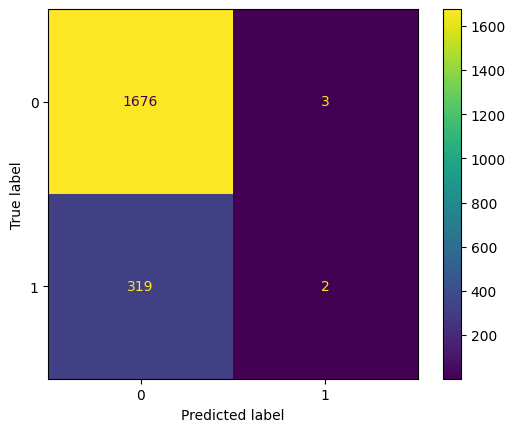

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_test and preds are now available from the previous cell

# Matriz de confusión
disp = ConfusionMatrixDisplay.from_predictions(y_test, preds)
plt.show()

### Curva ROC

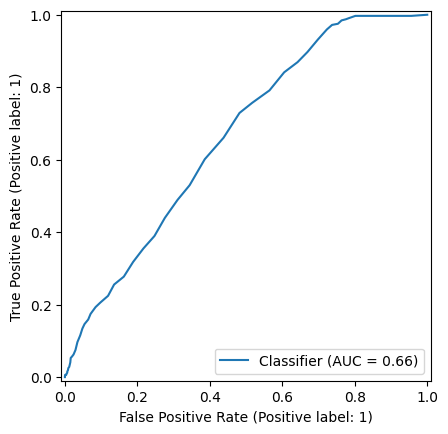

In [45]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, proba)


### Precision-Recall

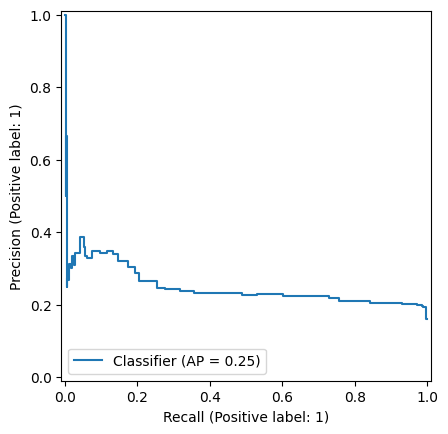

In [46]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_test, proba)


### Feature Importance

In [47]:
display(pipe_rf['model'].feature_importances_)

array([0.08054367, 0.09989498, 0.04579272, 0.09244087, 0.01642624,
       0.00887444, 0.09727504, 0.09646846, 0.09567762, 0.09950319,
       0.13053074, 0.06437287, 0.01126817, 0.0107283 , 0.00908167,
       0.01161067, 0.010715  , 0.00975953, 0.00903582])